<a href="https://colab.research.google.com/github/Yeoonsu/PythonPractice/blob/main/Fine_tuning_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# 1. Module Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [10]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cpu


In [11]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
#!unzip hymenoptera_data.zip

In [12]:
import os

In [13]:
# 3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기 (Train set,Test set 분리하기)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# 4. 데이터 확인하기 (1)
for (X_train, y_train) in dataloaders['train']:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


X_train: torch.Size([4, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([4]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: ignored

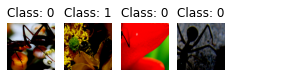

In [15]:
# 5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [16]:
# 6. 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

  if batch_idx % log_interval == 0:
    print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [17]:
# 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
          image = image.to(DEVICE)
          label = label.to(DEVICE)
          output = model(image)
          test_loss += criterion(output, label).item()
          prediction = output.max(1, keepdim = True)[1]
          correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
# 8. 파이토치 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기
import torchvision.models as models
model = models.resnet18(pretrained = False) # True 한번 해서 다운로드 받은 다음에 False 로 다시 바꿔줌
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE) # model.cuda() 라서 에러난거 gpu 사용으로 바꿔줌

In [21]:
model # 모델 모양 확인하기

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# 9. Optimizer, Objective Function 설정하기
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # 그대로 따라했는데 왜 에러나지?
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# 10. 미리 학습되지 않은 ResNet18 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기
for Epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 1 [240/244(98%)]	Train Loss: 0.706712

[EPOCH: 1], 	Test Loss: 0.1653, 	Test Accuracy: 66.01 % 

Train Epoch: 2 [240/244(98%)]	Train Loss: 1.216477

[EPOCH: 2], 	Test Loss: 0.2137, 	Test Accuracy: 64.05 % 

Train Epoch: 3 [240/244(98%)]	Train Loss: 0.897114

[EPOCH: 3], 	Test Loss: 0.2342, 	Test Accuracy: 58.17 % 

Train Epoch: 4 [240/244(98%)]	Train Loss: 0.520603

[EPOCH: 4], 	Test Loss: 0.2683, 	Test Accuracy: 45.75 % 

Train Epoch: 5 [240/244(98%)]	Train Loss: 0.755188

[EPOCH: 5], 	Test Loss: 0.1620, 	Test Accuracy: 61.44 % 

Train Epoch: 6 [240/244(98%)]	Train Loss: 0.298379

[EPOCH: 6], 	Test Loss: 0.1505, 	Test Accuracy: 67.97 % 

Train Epoch: 7 [240/244(98%)]	Train Loss: 0.551326

[EPOCH: 7], 	Test Loss: 0.1586, 	Test Accuracy: 65.36 % 

Train Epoch: 8 [240/244(98%)]	Train Loss: 0.316370

[EPOCH: 8], 	Test Loss: 0.2066, 	Test Accuracy: 52.29 % 

Train Epoch: 9 [240/244(98%)]	Train Loss: 0.759867

[EPOCH: 9], 	Test Loss: 0.1536, 	Test Accuracy: 66.01 % 

Train Epoc

In [32]:
# 11. IMAGENET 데이터로 미리 학습된 ResNet18 모델을 불러온 후 개미, 벌 이미지 데이터에 맞게 Fine Tuning 해보기
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(epoch, valid_loss, valid_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 10 [240/244(98%)]	Train Loss: 0.223109

[EPOCH: 1], 	Test Loss: 0.0723, 	Test Accuracy: 84.97 % 

Train Epoch: 10 [240/244(98%)]	Train Loss: 0.600300

[EPOCH: 2], 	Test Loss: 0.0795, 	Test Accuracy: 86.27 % 

Train Epoch: 10 [240/244(98%)]	Train Loss: 0.999256

[EPOCH: 3], 	Test Loss: 0.0910, 	Test Accuracy: 85.62 % 

Train Epoch: 10 [240/244(98%)]	Train Loss: 0.182218

[EPOCH: 4], 	Test Loss: 0.0606, 	Test Accuracy: 90.85 % 

Train Epoch: 10 [240/244(98%)]	Train Loss: 0.078131

[EPOCH: 5], 	Test Loss: 0.0601, 	Test Accuracy: 90.85 % 

Train Epoch: 10 [240/244(98%)]	Train Loss: 0.133291

[EPOCH: 6], 	Test Loss: 0.0520, 	Test Accuracy: 92.81 % 

Train Epoch: 10 [240/244(98%)]	Train Loss: 0.492389

[EPOCH: 7], 	Test Loss: 0.0732, 	Test Accuracy: 90.20 % 

Train Epoch: 10 [240/244(98%)]	Train Loss: 0.133675

[EPOCH: 8], 	Test Loss: 0.0843, 	Test Accuracy: 88.89 % 

Train Epoch: 10 [240/244(98%)]	Train Loss: 0.019276

[EPOCH: 9], 	Test Loss: 0.0472, 	Test Accuracy: 95.42 % 

T